In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

from tensorflow.python.keras.applications.efficientnet import EfficientNetB7 as tfk_BaseModel
from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

## Load Dataset

In [27]:
pd_train = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
pd_confusing_images = pd.read_csv('shopee-product-detection-dataset/confusing_images__loss_limit=9.csv').sort_values(by=['filename'])

pd_train['dir_filename']            = pd_train.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)
pd_confusing_images['dir_filename'] = pd_confusing_images.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)

In [28]:
mask = ~pd_train.set_index('dir_filename').index.isin(pd_confusing_images.set_index('dir_filename').index)
pd_train_clean = pd_train.loc[mask].copy()
pd_train_clean['category'] = pd_train_clean['category'].astype('str')
pd_train_clean.head()

,filename,category,dir_filename
50947,00017f8bf9d8a34dab8f9707a378dbe5.jpg,38,38/00017f8bf9d8a34dab8f9707a378dbe5.jpg
31622,00022314f9c58eb20d248ed239db3a52.jpg,16,16/00022314f9c58eb20d248ed239db3a52.jpg
34234,0002d098348d8358c44032903e117ade.jpg,28,28/0002d098348d8358c44032903e117ade.jpg
12787,000367a6ec58e9d1e4bc340d8d871dab.jpg,34,34/000367a6ec58e9d1e4bc340d8d871dab.jpg
38157,00042ddb52b8b5046c4f2eaee8c948ed.jpg,10,10/00042ddb52b8b5046c4f2eaee8c948ed.jpg


In [29]:
classes = np.unique(pd_train_clean['category'])
classes

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '5', '6', '7', '8', '9'], dtype=object)

In [30]:
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
batch_size=128

In [31]:
train_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
    validation_split=0.1,
    rotation_range=45,
    shear_range=20,
    zoom_range=[0.9, 1.1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 74790 validated image filenames belonging to 42 classes.
Found 8310 validated image filenames belonging to 42 classes.


## Prepare Model

In [6]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)
len(base_model.layers)

813

In [7]:
for layer in base_model.layers[:-16]:
  layer.trainable = False

In [8]:
model = tfk.Sequential([
    base_model,
    tfk.layers.GlobalMaxPooling2D(),
    tfk.layers.Dense(512, activation='relu'),
    #tfk.layers.Dense(256, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(42, activation='softmax', name='output_layer'),
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Model)       (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1311232   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 42)                5418      
Total params: 65,480,001
Trainable params: 6,759,754
Non-trainable params: 58,720,247
_________________________________________________________________


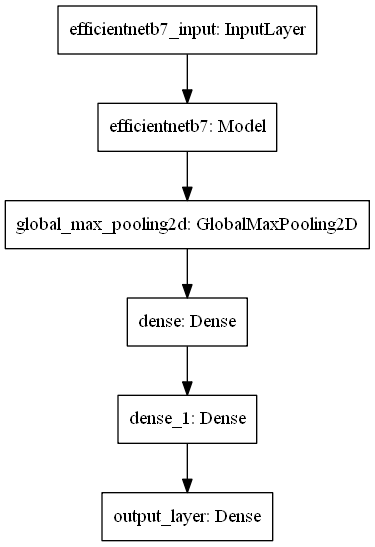

In [10]:
tfk.utils.plot_model(model)

In [11]:
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

## Train Model

In [6]:
model = tfk.models.load_model('model_clean_1.h5')

In [7]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

train_step_size = train_generator.n//train_generator.batch_size
val_step_size   = val_generator.n//val_generator.batch_size
print(train_step_size, val_step_size)

584 64


In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

checkpoint_dir = os.path.join('.model_files')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
    profile_batch = 100000000
)

In [10]:
history = model.fit(train_generator,
                    initial_epoch=8,
                    epochs=100,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[reduce_lr,
                              early_stop, 
                              checkpoint, 
                              tensorboard_callback
                              ]
                   )

Epoch 9/100
200/200 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.7679WARNING:tensorflow:From c:\users\franz cesista\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: .model_files/ckpt/assets
200/200 [==============================] - 635s 3s/step - loss: 1.4189 - accuracy: 0.7679 - val_loss: 1.1747 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 10/100
200/200 [==============================] - 662s 3s/step - loss: 1.4151 - accuracy: 0.7684 - val_loss: 1.1579 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 11/100
200/200 [==============================] - 732s 4s/step - loss: 1.4045 - accuracy: 0.7719 - val_loss: 1.1540 - val_accuracy: 0.857

In [11]:
model.save('model_clean_2.h5')

## Testing

In [2]:
model = tfk.models.load_model('model_clean_2.h5')

In [32]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 83100 validated image filenames belonging to 42 classes.


In [33]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(clean_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 2min 7s


In [21]:
# y_pred_ = y_pred.copy()
# 
# for i, c in enumerate(classes):
#     c = int(c)
#     y_pred_[:, c] = y_pred[:, i]

In [34]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

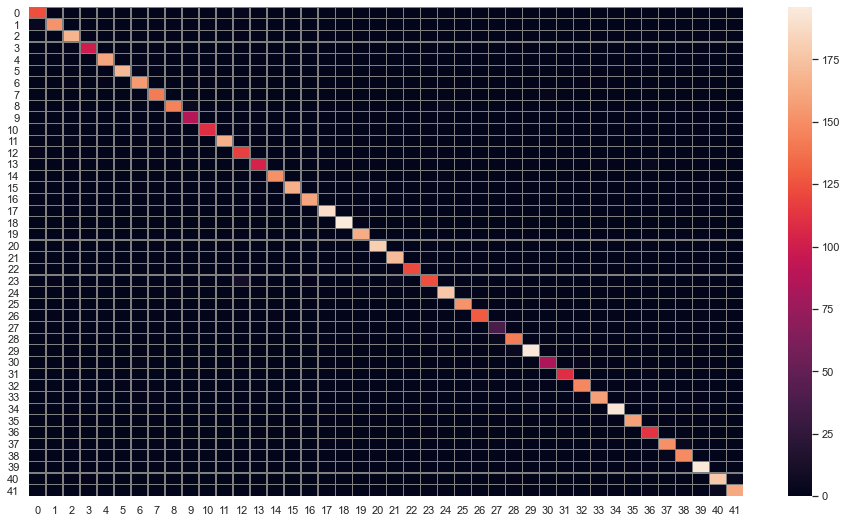

In [35]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix, linecolor='grey', linewidth=0.1)
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [36]:
def label_smoother(x, factor=0.1):
    xx = x.copy()
    xx[x == 1] = 1 - factor
    xx[x == 0] = factor / (y_true.shape[1] - 1)
    return xx

In [37]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 1.4597827
Accuracy: 0.963125


## Generate Submission

In [278]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv').sort_values(by=['filename'])
pd_test.head()

,filename,category
485,0004b03ad7eabfb3989727c461310a84.jpg,43
6397,0004d34271d0a0253f8a95d0746bae05.jpg,43
2181,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,43
2626,0012f125ad07123e69468ae1d1d59de4.jpg,43
2433,0015831b249b856e569e883a9dc6d4fa.jpg,43


In [279]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


In [281]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

96/96 [==============================] - 165s 2s/step


In [282]:
pd_submission = pd_test.copy()
pd_submission['category'] = list(map(lambda x : classes[x], y_pred.argmax(axis=1)))
pd_submission.head(10)

,filename,category
485,0004b03ad7eabfb3989727c461310a84.jpg,12
6397,0004d34271d0a0253f8a95d0746bae05.jpg,16
2181,000d4ad3d0a372fd6eea2fee6bf738ef.jpg,40
2626,0012f125ad07123e69468ae1d1d59de4.jpg,22
2433,0015831b249b856e569e883a9dc6d4fa.jpg,12
6002,001640e7947935ad28d00f740c3eaefc.jpg,1
8633,00196f6ef552b2c4d78365818acdbce2.jpg,40
2935,001d40e7718c79ed31750d6c988a90fc.jpg,30
12092,001eeb075533bafbfb8e4a6f9e4b8765.jpg,37
10161,0022bd7f6b85fe98edd3291d9824ee6c.jpg,9


In [283]:
pd_submission.to_csv('submission_2.csv', index=False)

### Test

In [297]:
image = Image.open('shopee-product-detection-dataset/test/000d4ad3d0a372fd6eea2fee6bf738ef.jpg')
#image = Image.open('shopee-product-detection-dataset/train/24/0a2f8630539a6028bb636f1bba990fb1.jpg')
image = image.resize(input_shape[:2])
image = np.asarray(image)
image = tfk_preprocess_input(image)
image.shape

(256, 256, 3)

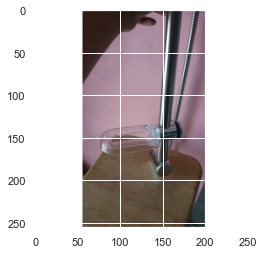

In [298]:
plt.imshow(image)

In [299]:
res = model.predict(np.expand_dims(image, axis=0))

In [300]:
res

array([[0.00263054, 0.00547645, 0.01066356, 0.00936576, 0.00568813,
        0.01023893, 0.01240693, 0.01074474, 0.002801  , 0.0039913 ,
        0.00477088, 0.00920071, 0.00228364, 0.06766966, 0.00348781,
        0.00132776, 0.00257775, 0.00269085, 0.00320876, 0.00121288,
        0.00842926, 0.0039152 , 0.00244225, 0.00485736, 0.0021809 ,
        0.01233215, 0.01175185, 0.01738959, 0.002115  , 0.02983152,
        0.00948595, 0.00653848, 0.05547606, 0.01896148, 0.00681085,
        0.6060216 , 0.00262597, 0.00854894, 0.0060868 , 0.00229492,
        0.00390173, 0.00556413]], dtype=float32)

In [301]:
class_pred = res.argmax(axis=-1)[0]
class_pred

35

In [302]:
classes[class_pred]

'40'